In [ ]:
# Import libraries
import pandas as pd
from scipy import io
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Path to the folder where GEO files 
base = "."  

# Read in the matrix
print("Reading matrix...")
mat = io.mmread(f"{base}/GSE211644_fresh_matrix.mtx.gz").T.tocsr()

print("Reading gene and barcode lists...")
genes = pd.read_csv(f"{base}/GSE211644_fresh_genes.tsv.gz", sep="\t", header=None)
barcodes = pd.read_csv(f"{base}/GSE211644_fresh_barcodes.tsv.gz", sep="\t", header=None)
# create pandas DataFrame
df=pd.DataFrame.sparse.from_spmatrix(mat)
df.columns = genes.iloc[:, 0].astype(str).values
df.index = barcodes.iloc[:, 0].astype(str).values

print("Reading metadata...")
meta = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv.gz")

meta["sample"] = meta["barcode"].str.split("_").str[0]

meta.index = meta["barcode"]
df = df.reindex(meta.index)
df["barcode"] = df.index

# Inspect what samples exist 
print("Unique samples found in metadata:")
print(meta["sample"].unique())

# Subset for MDA1 and MDA2
df_MDA1 = df[df.index.isin(meta[meta["sample"] == "MDA1"]["barcode"])]
df_MDA2= df[df.index.isin(meta[meta["sample"] == "MDA2"]["barcode"])]

Reading matrix...
Reading gene and barcode lists...
Reading metadata...
Unique samples found in metadata:
['MDA1' 'MDA2']


In [ ]:
df["cluster"]= meta["cluster"][df.index]
df["patient"]= df["barcode"].str.extract(r'(MDA\d_\w\d\d)')
df["cohort"]= df["barcode"].str.extract(r'(MDA\d)')
df["tissue type"]= df["barcode"].str.extract(r'_(\w)')
df["tissue type"]=df["tissue type"].replace({"U":"uninvolved", "T":"tumor"})
patient_cluster_counts = df.groupby(['patient', 'cluster']).size().unstack(fill_value=0)
cohort = df.drop_duplicates("patient").set_index("patient")["cohort"] 
type= df.drop_duplicates("patient").set_index("patient")["tissue type"]
categories = ["CD4 - FOXP3","CD4 - CXCR4","CD4 - CCR7","CD4 - CXCL13", "CD4 - MX1","CD8 - GZMK","CD8 - CXCR6/IL7R","CD8 - ZNF683","CD8 - GZMB/PRF1","CD8 - CXCL13","CD8 - CCR7/IL7R","CD8 - MX1", "Cycling"][::-1]

barcode
MDA1_T02_AAAGTAGTCTCTTGAT         tumor
MDA1_T02_ACACCGGTCGCGATCG         tumor
MDA1_T02_TAAACCGCAGTCAGAG         tumor
MDA1_T04_AAACGGGTCTCGATGA         tumor
MDA1_T04_AACCATGGTAGCAAAT         tumor
                                ...    
MDA2_U24_CTGCCTAAGCCACGCT    uninvolved
MDA2_U24_GGGCACTAGACCGGAT    uninvolved
MDA2_U24_TAAGAGACAGCTTAAC    uninvolved
MDA2_U17_ATGGGAGCATTGGCGC    uninvolved
MDA2_U17_GATCTAGTCTACTCAT    uninvolved
Name: tissue type, Length: 22164, dtype: object


In [ ]:


df_counts = patient_cluster_counts[categories]
df_proportion = df_counts.apply(lambda x: x / x.sum(), axis=1)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
dist = pdist(df_proportion.values, metric='euclidean')
link = linkage(dist, method='average')
leaves = leaves_list(link)
df_proportion = df_proportion.iloc[leaves, :]


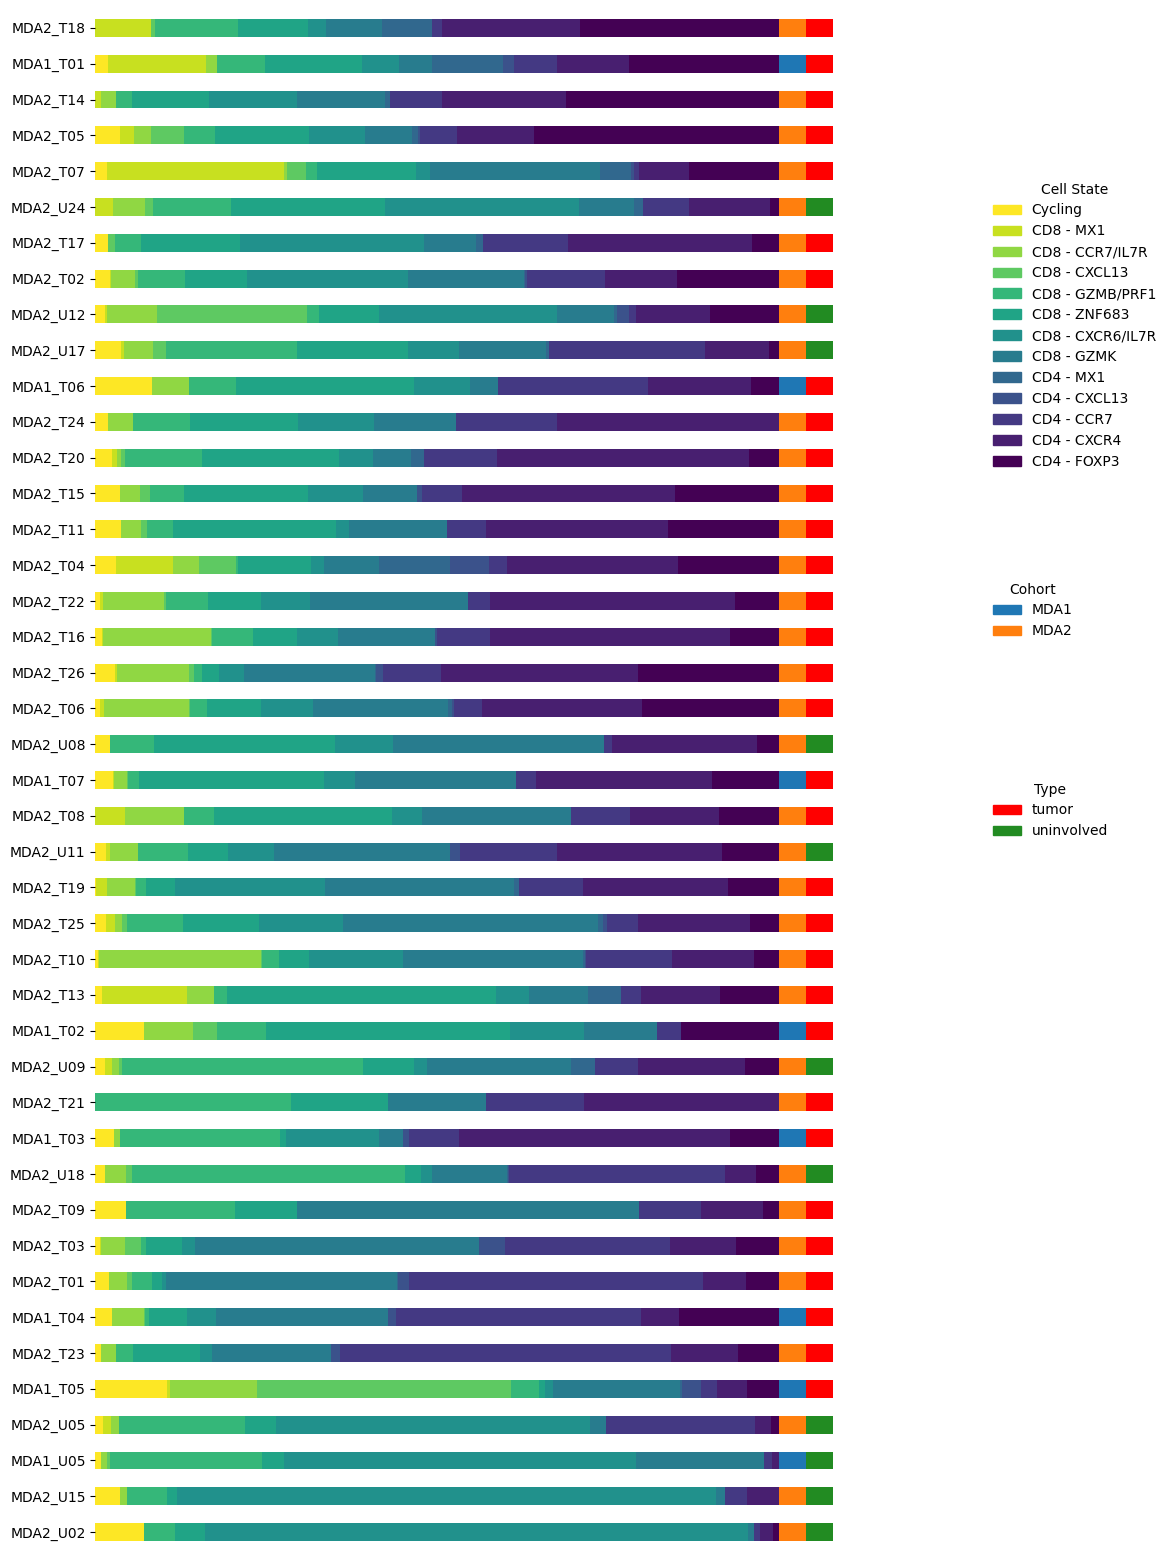

In [ ]:


categories = df_proportion.columns
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(categories)))

unique_cohorts = cohort.unique()
cohort_color_map = dict(zip(unique_cohorts, plt.cm.tab10.colors[:len(unique_cohorts)]))
type_color_map = {'tumor': 'red', 'uninvolved': 'forestgreen'}  # example

fig, ax = plt.subplots(figsize=(10, 20))

df_proportion.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=colors[::-1],
    legend=False,
)


ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none')
for spine in ['top', 'right', 'left', 'bottom']:
    spine_obj = ax.spines[spine]
    spine_obj.set_visible(False)

ax.set_ylabel('')
ax.set_xlabel('')

y_positions = np.arange(len(df_proportion))

for i, patient in enumerate(df_proportion.index):
    ax.barh(
        y=i,
        width=0.04,
        left=1,
        height=0.5,
        color=cohort_color_map[cohort[patient]],
    )
    ax.barh(
        y=i,
        width=0.04,
        left= 1.04,
        height=.5,
        color=type_color_map[type[patient]],
    )

fig.legend().set_visible(False)

cluster_handles = [
    plt.Rectangle((0, 0), 1, 1, color=color)
    for color in colors[::-1]
]
fig.legend(
    cluster_handles,
    categories,
    title="Cell State",
    loc="upper left",
    bbox_to_anchor=(1.01, .8),  
    frameon=False,
)

cohort_handles = [
    plt.Rectangle((0, 0), 1, 1, color=cohort_color_map[c])
    for c in unique_cohorts
]
fig.legend(
    cohort_handles,
    unique_cohorts,
    title="Cohort",
    loc="upper left",
    bbox_to_anchor=(1.01, 0.6), 
    frameon=False,
)

type_handles = [
    plt.Rectangle((0, 0), 1, 1, color=type_color_map[t])
    for t in type_color_map
]
fig.legend(
    type_handles,
    list(type_color_map.keys()),
    title="Type",
    loc="upper left",
    bbox_to_anchor=(1.01, 0.5),  
    frameon=False,
)
